In [19]:
import numpy as np
import scripts
import geopandas
import matplotlib.pyplot as plt
import stoclust as sc
import matplotlib.lines as ln
from tqdm import tqdm

import plotly.graph_objects as go
import plotly.express as px
import scipy.linalg as la
import os

import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
rc('font',**{'family':'cmr10','size':20})
rc('text', usetex=1)

def draw_pie(dist, 
             xpos, 
             ypos, 
             size, colors,scale=1,
             ax=None,):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    for j in range(len(pie)-1):
        r2 = pie[j+1]
        r1 = pie[j]
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])
        rot = np.column_stack([[-v for v in y], x])

        ax.scatter([xpos], [ypos], marker=xy, s=size,c=colors[j])
    circle = plt.Circle((xpos,ypos),size/165*scale,color='k',fill=False,linewidth=size/500)
    ax.add_patch(circle)
    return ax

def kt(x,y):
    n = len(x)
    concordant = (((x[:,None]-x[None,:])*(y[:,None]-y[None,:]))>0).sum()/2
    discordant = (((x[:,None]-x[None,:])*(y[:,None]-y[None,:]))<0).sum()/2
    return 2*(concordant-discordant)/(n*(n-1))

# Initialization

In [2]:
gtap = scripts.GTAP()
num_reg = gtap.regions.items.size
num_commod = gtap.commodities.items.size
num_fac = gtap.factors.items.size

In [3]:
new_reg = gtap.megaregions.at_scale(1)
new_commod = gtap.commodities.at_scale(2)
new_fac = gtap.factors.at_scale(2)

num_new_reg = new_reg.clusters.size
num_new_commod = new_commod.clusters.size
num_new_fac = new_fac.clusters.size

In [4]:
lab_flows_null = sc.utils.stoch(np.load('scripts/data/computed/flows/null/labor.npy',),axis=(1,2))
co2_flows_null = sc.utils.stoch(np.load('scripts/data/computed/flows/null/carbon.npy',),axis=(1,2))
val_flows_null = np.load('scripts/data/computed/flows/null/values.npy',)

lab_flows_ind = sc.utils.stoch(np.load('scripts/data/computed/flows/industry/labor.npy',),axis=(0,1))
co2_flows_ind = sc.utils.stoch(np.load('scripts/data/computed/flows/industry/carbon.npy',),axis=(0,1))
val_flows_ind = np.load('scripts/data/computed/flows/industry/values.npy',)

# GTAP MODEL

## Carbon

For the GTAP 8 data, we plot the Lorenz curves for $(e^{(\mathrm{CO}_2)}_{ri},v_{ri})$, $(\hat{e}^{(\mathrm{CO}_2)}_{r},\hat{y}_{r})$, $(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{x}_r)$ and $(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{y}_r)$. We then print whether or not eco-majorization holds in this case; that is, if 
$$
(\hat{e}^{(\mathrm{CO}_2)}_{r},\hat{y}_{r}) \succeq (\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{y}_r)
$$

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/lorenz.py:8: RuntimeWarning:

divide by zero encountered in true_divide

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/lorenz.py:8: RuntimeWarning:

invalid value encountered in true_divide



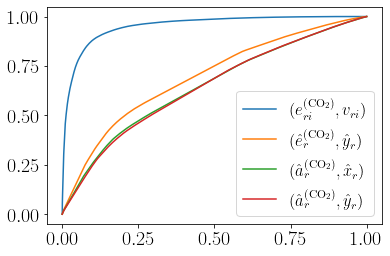

Ecomajorization:  True


In [9]:
co2_reg_ind = co2_flows_ind.sum(axis=1).reshape([num_reg,num_commod]).sum(axis=1)
val_reg_ind = val_flows_ind.sum(axis=1).reshape([num_reg,num_commod]).sum(axis=1)

co2_attr_reg_ind = co2_flows_ind.sum(axis=0).reshape([num_reg,3]).sum(axis=1)
val_attr_reg_ind = val_flows_ind.sum(axis=0).reshape([num_reg,3]).sum(axis=1)

xs,ys = scripts.lorenz_curve(co2_flows_ind.sum(axis=1),val_flows_ind.sum(axis=1))
xs_2,ys_2 = scripts.lorenz_curve(co2_reg_ind,val_reg_ind)
xs_3,ys_3 = scripts.lorenz_curve(co2_attr_reg_ind,val_attr_reg_ind)
xs_4,ys_4 = scripts.lorenz_curve(co2_attr_reg_ind,val_reg_ind)

plt.plot(xs,ys,label=r'$(e^{(\mathrm{CO}_2)}_{ri},v_{ri})$')
plt.plot(xs_2,ys_2,label=r'$(\hat{e}^{(\mathrm{CO}_2)}_{r},\hat{y}_{r})$')
plt.plot(xs_3,ys_3,label=r'$(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{x}_r)$')
plt.plot(xs_4,ys_4,label=r'$(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{y}_r)$')

plt.legend(fontsize='small')

plt.show()

print('Ecomajorization: ',scripts.is_majorized(co2_reg_ind,val_reg_ind,co2_attr_reg_ind,val_reg_ind))

## Labor

We do the same for Labor.

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/lorenz.py:8: RuntimeWarning:

invalid value encountered in true_divide



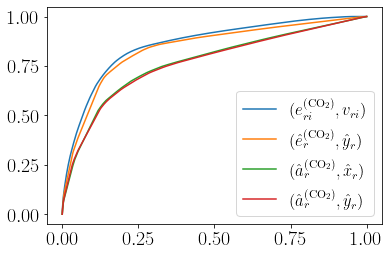

Ecomajorization:  True


In [12]:
lab_reg_ind = lab_flows_ind.sum(axis=1).reshape([num_reg,num_commod]).sum(axis=1)
val_reg_ind = val_flows_ind.sum(axis=1).reshape([num_reg,num_commod]).sum(axis=1)

lab_attr_reg_ind = lab_flows_ind.sum(axis=0).reshape([num_reg,3]).sum(axis=1)
val_attr_reg_ind = val_flows_ind.sum(axis=0).reshape([num_reg,3]).sum(axis=1)

xs,ys = scripts.lorenz_curve(lab_flows_ind.sum(axis=1),val_flows_ind.sum(axis=1))
xs_2,ys_2 = scripts.lorenz_curve(lab_reg_ind,val_reg_ind)
xs_3,ys_3 = scripts.lorenz_curve(lab_attr_reg_ind,val_attr_reg_ind)
xs_4,ys_4 = scripts.lorenz_curve(lab_attr_reg_ind,val_reg_ind)

plt.plot(xs,ys,label=r'$(e^{(\mathrm{CO}_2)}_{ri},v_{ri})$')
plt.plot(xs_2,ys_2,label=r'$(\hat{e}^{(\mathrm{CO}_2)}_{r},\hat{y}_{r})$')
plt.plot(xs_3,ys_3,label=r'$(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{x}_r)$')
plt.plot(xs_4,ys_4,label=r'$(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{y}_r)$')

plt.legend(fontsize='small')

plt.show()

print('Ecomajorization: ',scripts.is_majorized(lab_reg_ind,val_reg_ind,lab_attr_reg_ind,val_reg_ind))

# Null Model

Now, for the standard null model (without varying parameters), we will randomly select a null model sample and do the same tests for labor and carbon. More rigorously, we will compute the proportion of null model samples where ecomajorization holds, as well as the average dismajorization. In addition, we will plot maps like the one from the manuscript, displaying the relationship between regional intensity and embodied impact flows.

## Labor

247


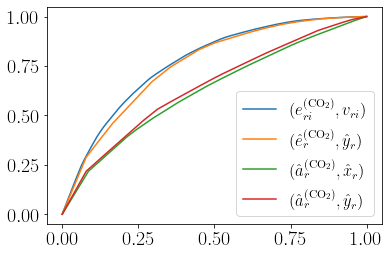

Ecomajorization:  True


In [14]:
k = np.random.choice(np.arange(1000))
print(k)
lab_reg_null = lab_flows_null[k].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)
val_reg_null = val_flows_null[k].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)

lab_attr_reg_null = lab_flows_null[k].sum(axis=0).reshape([num_new_reg,3]).sum(axis=1)
val_attr_reg_null = val_flows_null[k].sum(axis=0).reshape([num_new_reg,3]).sum(axis=1)

xs,ys = scripts.lorenz_curve(lab_flows_null[k].sum(axis=1),val_flows_null[k].sum(axis=1))
xs_2,ys_2 = scripts.lorenz_curve(lab_reg_null,val_reg_null)
xs_3,ys_3 = scripts.lorenz_curve(lab_attr_reg_null,val_attr_reg_null)
xs_4,ys_4 = scripts.lorenz_curve(lab_attr_reg_null,val_reg_null)

plt.plot(xs,ys,label=r'$(e^{(\mathrm{CO}_2)}_{ri},v_{ri})$')
plt.plot(xs_2,ys_2,label=r'$(\hat{e}^{(\mathrm{CO}_2)}_{r},\hat{y}_{r})$')
plt.plot(xs_3,ys_3,label=r'$(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{x}_r)$')
plt.plot(xs_4,ys_4,label=r'$(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{y}_r)$')

plt.legend(fontsize='small')

plt.show()

print('Ecomajorization: ',scripts.is_majorized(lab_reg_null,val_reg_null,lab_attr_reg_null,val_reg_null))

In [15]:
lab_dismajorization_null = []
lab_reflux_null = []
lab_xis_null = []
for k in tqdm(range(1000)):
    lab_reg_null = lab_flows_null[k].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)
    val_reg_null = val_flows_null[k].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)
    lab_attr_reg_null = lab_flows_null[k].sum(axis=0).reshape([num_new_reg,3]).sum(axis=1)

    lab_dismajorization_null.append(scripts.dismajorization(lab_reg_null,val_reg_null,lab_attr_reg_null,val_reg_null))
    xi_by_reg = (lab_reg_null-lab_attr_reg_null)
    lab_xis_null.append(xi_by_reg)

lab_dismajorization_null = np.array(lab_dismajorization_null)
lab_reflux_null = np.array(lab_reflux_null)
lab_xis_null = np.array(lab_xis_null)

100%|██████████| 1000/1000 [00:02<00:00, 474.17it/s]


In [16]:
print('Null chance of eco-majorization:',(lab_dismajorization_null<1e-10).sum()/1000*100,'%')
print('Null average dismajorization:',100*(lab_dismajorization_null).sum()/1000,'%')

Null chance of majorization: 100.0 %
Null average dismajorization: 9.2148511043888e-16 %


We see that the null chance of majorization is $100\%$ for labor, with a zero average dismajorization in consequence.

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/GTAP.py:653: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/GTAP.py:654: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/GTAP.py:655: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/G

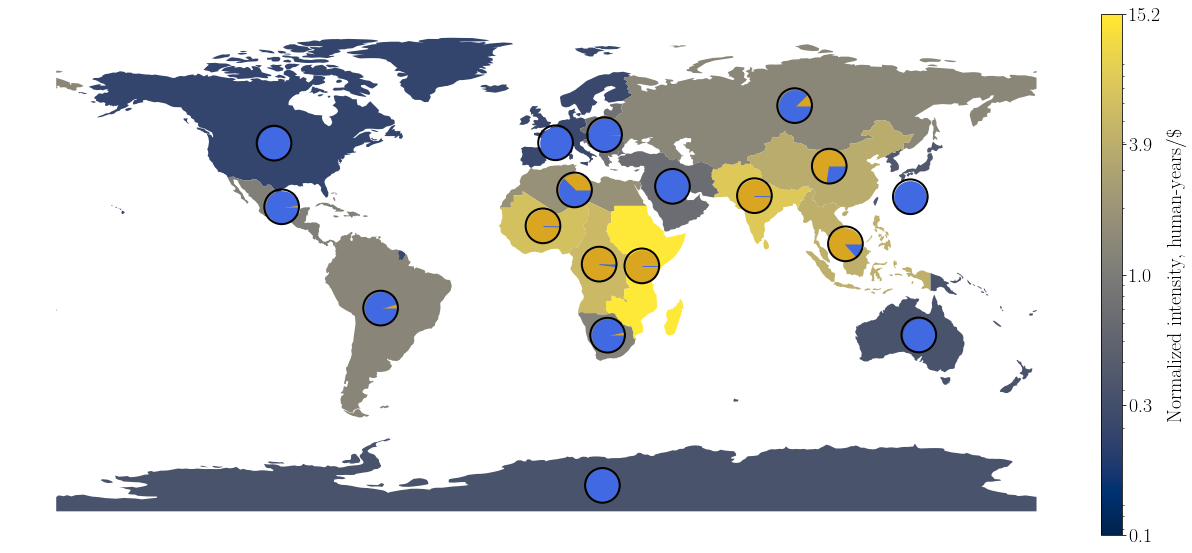

In [17]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
rc('font',**{'family':'cmr10','size':20})
rc('text', usetex=1)
bipart = gtap.megaregions.at_scale(1)

geo = gtap.geodata()
geometry = []

c_data = (gtap.megaregions.measure(lab_reg_ind)[bipart.clusters.in_superset]/gtap.megaregions.measure(val_reg_ind)[bipart.clusters.in_superset])

rng = np.exp(np.max(np.abs(np.log(c_data))))

pie_data = np.average((lab_xis_null>0),axis=0)
#data = rhos[np.array([28,44,106,121,133])]

for c in bipart.clusters:
    geometry.append(geo[geo.code.isin([r.upper() for r in bipart[c].elements])].unary_union)

df = {'data': c_data, 'geometry':geometry, 'id':np.arange(bipart.clusters.size), 'name':bipart.clusters.elements}
G = geopandas.GeoDataFrame(df,crs=geo.crs,)



fig,ax = plt.subplots(1,1,figsize=(20,40/0.95))

xs = np.array([G.centroid[i].x for i in range(bipart.clusters.size)])
ys = np.array([G.centroid[i].y for i in range(bipart.clusters.size)])

xs[bipart.clusters.ind['NORTHERN AMERICA']] = -100
ys[bipart.clusters.ind['NORTHERN AMERICA']] = 45

xs[bipart.clusters.ind['WESTERN EUROPE']] -= 5
ys[bipart.clusters.ind['WESTERN EUROPE']] -= 10

ys[bipart.clusters.ind['EAST ASIA']] -= 12

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

G.plot(ax=ax,column='data',cmap='cividis',legend=True,norm=colors.LogNorm(vmin=1/rng, vmax=rng),cax=cax,
        legend_kwds={'orientation': "vertical",
                     'label':r'Normalized intensity, human-years$/\$$',
                     'ticks':[1/rng,1/np.sqrt(rng),1,np.sqrt(rng),rng],
                     'format':'%.1f',})

#G.boundary.plot(ax=ax,color='k',)

for r in range(bipart.clusters.size):
    draw_pie([pie_data[r],1-pie_data[r]],xs[r],ys[r],1000,ax=ax,colors=['goldenrod','royalblue'],scale=1.05)
ax.set_axis_off()
plt.show()

We compute the Kendall's $\tau$ correlation between the null likelihood of net exports $\Xi_r^\alpha$ and the intensity $f^{(\alpha)}_r$:

In [20]:
kt(c_data,pie_data)

0.9607843137254902

## Carbon

We now do the same tests for $\mathrm{CO}_2$.

28


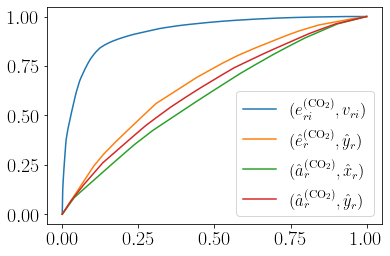

Ecomajorization:  True


In [22]:
k = np.random.choice(np.arange(1000))
print(k)
co2_reg_null = co2_flows_null[k].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)
val_reg_null = val_flows_null[k].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)

co2_attr_reg_null = co2_flows_null[k].sum(axis=0).reshape([num_new_reg,3]).sum(axis=1)
val_attr_reg_null = val_flows_null[k].sum(axis=0).reshape([num_new_reg,3]).sum(axis=1)

xs,ys = scripts.lorenz_curve(co2_flows_null[k].sum(axis=1),val_flows_null[k].sum(axis=1))
xs_2,ys_2 = scripts.lorenz_curve(co2_reg_null,val_reg_null)
xs_3,ys_3 = scripts.lorenz_curve(co2_attr_reg_null,val_attr_reg_null)
xs_4,ys_4 = scripts.lorenz_curve(co2_attr_reg_null,val_reg_null)

plt.plot(xs,ys,label=r'$(e^{(\mathrm{CO}_2)}_{ri},v_{ri})$')
plt.plot(xs_2,ys_2,label=r'$(\hat{e}^{(\mathrm{CO}_2)}_{r},\hat{y}_{r})$')
plt.plot(xs_3,ys_3,label=r'$(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{x}_r)$')
plt.plot(xs_4,ys_4,label=r'$(\hat{a}^{(\mathrm{CO}_2)}_{r},\hat{y}_r)$')

plt.legend(fontsize='small')

plt.show()

print('Ecomajorization: ',scripts.is_majorized(co2_reg_null,val_reg_null,co2_attr_reg_null,val_reg_null))

In [23]:
co2_dismajorization_null = []
co2_reflux_null = []
co2_xis_null = []
total_global_null = []
for k in tqdm(range(1000)):
    co2_reg_null = co2_flows_null[k].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)
    val_reg_null = val_flows_null[k].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)
    co2_attr_reg_null = co2_flows_null[k].sum(axis=0).reshape([num_new_reg,3]).sum(axis=1)

    co2_dismajorization_null.append(scripts.dismajorization(co2_reg_null,val_reg_null,co2_attr_reg_null,val_reg_null))
    
    self_co2 = np.diag(co2_flows_null[k].reshape([num_new_reg,num_new_commod,num_new_reg,3]).sum(axis=(1,3)))
    xi_by_reg = (co2_reg_null-co2_attr_reg_null)/(co2_reg_null+co2_attr_reg_null-self_co2)
    co2_xis_null.append(xi_by_reg)
    total_global_null.append(co2_attr_reg_null.sum()-self_co2.sum())

co2_dismajorization_null = np.array(co2_dismajorization_null)
co2_reflux_null = np.array(co2_reflux_null)
co2_xis_null = np.array(co2_xis_null)
total_global_null = np.array(total_global_null)

100%|██████████| 1000/1000 [00:02<00:00, 385.63it/s]


In [24]:
print('Null chance of majorization:',(co2_dismajorization_null<1e-10).sum()/1000*100,'%')
print('Null average dismajorization:',100*(co2_dismajorization_null).sum()/1000,'%')

Null chance of majorization: 72.39999999999999 %
Null average dismajorization: 5.87029205485948 %


/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/GTAP.py:653: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/GTAP.py:654: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/GTAP.py:655: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Volumes/LaCie/Data_Work/projects/world-systems-gtap/main/scripts/G

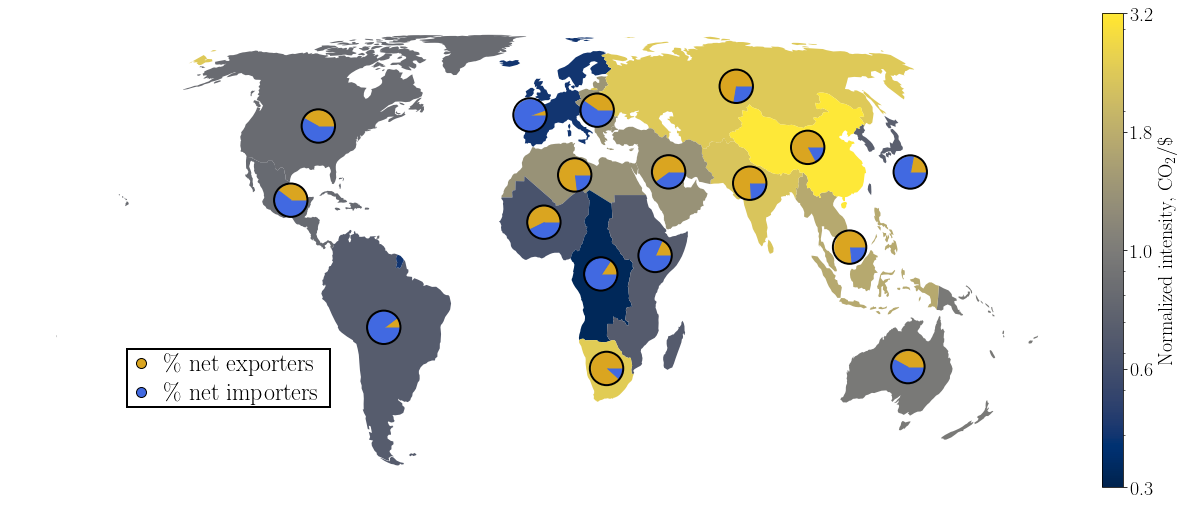

In [25]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
rc('font',**{'family':'cmr10','size':20})
rc('text', usetex=1)
bipart = gtap.megaregions.at_scale(1)

geo = gtap.geodata()
geometry = []

c_data = (gtap.megaregions.measure(co2_reg_ind)[bipart.clusters.in_superset]/gtap.megaregions.measure(val_reg_ind)[bipart.clusters.in_superset])[:-1]
rng = np.exp(np.max(np.abs(np.log(c_data))))

s_data = np.ones([17])
pie_data = np.average((co2_xis_null>0),axis=0)[:-1]
#data = rhos[np.array([28,44,106,121,133])]

for c in bipart.clusters:
    if c != 'REST OF WORLD':
        geometry.append(geo[geo.code.isin([r.upper() for r in bipart[c].elements])].unary_union)

print(len(c_data))
df = {'data': c_data, 'geometry':geometry, 'id':np.arange(bipart.clusters.size-1), 'name':bipart.clusters.elements[:-1]}
G = geopandas.GeoDataFrame(df,crs=geo.crs,)
G = G.to_crs(epsg=8857)



fig,ax = plt.subplots(1,1,figsize=(20,40/0.95))

xs = np.array([G.centroid[i].x for i in range(bipart.clusters.size-1)])
ys = np.array([G.centroid[i].y for i in range(bipart.clusters.size-1)])

xs[bipart.clusters.ind['NORTHERN AMERICA']] -= 5e5
ys[bipart.clusters.ind['NORTHERN AMERICA']] -= 1e6

xs[bipart.clusters.ind['WESTERN EUROPE']] -= 1e6
ys[bipart.clusters.ind['WESTERN EUROPE']] -= 5e5

xs[bipart.clusters.ind['EAST ASIA']] += 1e6
ys[bipart.clusters.ind['EAST ASIA']] -= 1e6

xs[bipart.clusters.ind['EAST AFRICA']] += 4e5
ys[bipart.clusters.ind['EAST AFRICA']] += 7e5

xs[bipart.clusters.ind['C. AMERICA & CARIBBEAN']] += 1e5
ys[bipart.clusters.ind['C. AMERICA & CARIBBEAN']] -= 1e5

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

G.plot(ax=ax,column='data',cmap='cividis',legend=True,norm=colors.LogNorm(vmin=1/rng, vmax=rng),cax=cax,
        legend_kwds={'orientation': "vertical",
                     'label':r'Normalized intensity, $\mathrm{CO}_2/\$$',
                     'ticks':[1/rng,1/np.sqrt(rng),1,np.sqrt(rng),rng],
                     'format':'%.1f',})

#G.boundary.plot(ax=ax,color='k',)

for r in range(bipart.clusters.size-1):
    draw_pie([pie_data[r],1-pie_data[r]],xs[r],ys[r],1000*s_data[r],ax=ax,colors=['goldenrod','royalblue'],scale=1e5*0.95/np.sqrt(s_data[r]))
ax.set_axis_off()

ax.scatter([-1.4e7],[-3e6],c='goldenrod',edgecolor='k',marker='o',s=100)
ax.scatter([-1.4e7],[-4e6],c='royalblue',edgecolor='k',marker='o',s=100)
rect = plt.Rectangle((-1.45e7,-4.5e6),0.7e7,2e6,fill=False,edgecolor='k',linewidth=2)
ax.add_patch(rect)
ax.annotate('\% net exporters',
            xy=(-1.32e7, -3.25e6), 
            xytext=(0,0),   
            xycoords='data',
            textcoords='offset pixels',
            fontsize='large',color='k')
ax.annotate('\% net importers',
            xy=(-1.32e7, -4.25e6), 
            xytext=(0,0),   
            xycoords='data',
            textcoords='offset pixels',
            fontsize='large',color='k')
if not os.path.isdir(os.path.abspath('plots/')):
    os.mkdir(os.path.abspath('plots/'))
plt.savefig('plots/carbon_flows.pdf',bbox_inches='tight')
plt.show()

Lastly calculating the Kendall's $\tau$ correlation between intensity and null likelihood of net exports:

In [26]:
kt(c_data,pie_data)

0.6764705882352942